In [ ]:
import numpy as np; import pandas as pd; import sklearn as sk; import matplotlib.pyplot as plt; import seaborn as sns; import os
import random; from scipy import stats; from sklearn import preprocessing; from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy.lib.recfunctions as rfn; import statsmodels.api as sm; from statsmodels.graphics.regressionplots import abline_plot
import numpy as np; from sklearn.linear_model import LinearRegression; from sklearn.metrics import mean_squared_error, r2_score
import math; from sklearn import linear_model
from numpy import linalg; from scipy import stats; import cv2; import math; from matplotlib import cm; from matplotlib import colors
import matplotlib as mpl; from matplotlib.ticker import (AutoMinorLocator, MultipleLocator); import scipy.stats as st; import scipy as sp
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import os; print(os.getcwd())
from os import listdir
from os.path import isfile, join
from PIL import Image
from matplotlib import cm
import matplotlib.patches as mpatches
from google.colab import drive
drive.mount('/content/gdrive')

# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
try: 
    import torchbearer
except:
    !pip install torchbearer

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from numpy import linalg
from scipy import stats
import cv2
import math
from matplotlib import cm
from matplotlib import colors
import matplotlib as mpl
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import scipy.stats as st
import torch.optim as optim
torch.set_printoptions(precision=4,sci_mode=False)
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import random
import sys
import io
import torchbearer
from torchbearer import Trial
from torchbearer.callbacks.decorators import on_end_epoch

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/content
Mounted at /content/gdrive
     |████████████████████████████████| 138 kB 6.8 MB/s 
Sat Aug 28 14:22:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------------

Steps to load data and train model


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

maxlen = 40
step = 1

##########################################################################################
# 1) LOAD AND PRE-PROCESS THE DATA
##########################################################################################
dforig = pd.read_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/df_all_20210725pm1_LANDMARK_allcomps.csv")
df = dforig.rename({"Unnamed: 0":"index"},axis=1)
df = df.loc[:,["comp","TID","MID","index","PID","act","T","deltaT","x0","y0","s","theta","scrad"]]
df["y0"] = dforig["x0"]
df["x0"] = dforig["y0"]

df.columns = ['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'deltaT', 'x', 'y', 's', 'theta', 'scrad']

##########
# Filter down to only a subset of matches from a subset of teams
##########
#subset of teams first
teams_list = pd.read_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/3progressJUL/soccer_teams_to_import.csv")
idx = np.repeat(False,len(df))
for i in range(len(teams_list)):
  idx0 = np.logical_and(df['comp'] == teams_list.loc[i,'Comp'],df['TID'] == teams_list.loc[i,'wyId'])
  idx = np.logical_or(idx,idx0)
df = df.loc[idx,:]

#subset of matches of teams
idx = np.repeat(False,len(df))
np.random.seed(123)
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  tempmatches = np.unique(df.loc[df["TID"]==tempteam['wyId'],"MID"])
  num_matches_to_choose = tempteam['trnval'] + tempteam['tst']
  matches_to_keep = np.random.choice(tempmatches,num_matches_to_choose,replace=False)
  idx0 = np.logical_and(df['comp'] == tempteam['Comp'],df['TID'] == tempteam['wyId'])
  idx1 = np.logical_and(idx0,np.isin(df['MID'],matches_to_keep))
  idx = np.logical_or(idx,idx1)
df = df.loc[idx,:]

#train and test
teams_list['trnval_MIDs'] = None
teams_list['trnval_MIDs'] = teams_list['trnval_MIDs'].astype(object)
teams_list['tst_MIDs'] = None
teams_list['tst_MIDs'] = teams_list['tst_MIDs'].astype(object)
teams_list['n_trnval'] = 0
teams_list['n_tst'] = 0
np.random.seed(123)
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  tempteam_allmatches = np.unique(df.loc[df["TID"] == tempteam["wyId"],"MID"])
  np.random.shuffle(tempteam_allmatches) # shuffle in place
  teams_list['trnval_MIDs'][i] = tempteam_allmatches[:tempteam["trnval"]]
  teams_list['tst_MIDs'][i] = tempteam_allmatches[tempteam["trnval"]:]
  teams_list['n_trnval'][i] = np.sum(np.isin(df["MID"],teams_list['trnval_MIDs'][i]))
  teams_list['n_tst'][i] = np.sum(np.isin(df["MID"],teams_list['tst_MIDs'][i]))

df = df.sort_values(by=['TID','MID','index'])
df = df.reset_index(drop=True)

##########
# Feature engineering
##########

#simplify actions further
##########
df = df.loc[df["act"]!="x",:]
df = df.reset_index(drop=True)
df.loc[df["act"]=="0","act"] = "p"
df.loc[df["act"]=="1","act"] = "p"
df.loc[df["act"]=="2","act"] = "x"    
df.loc[df["act"]=="3","act"] = "p"
df.loc[df["act"]=="4","act"] = "x"
df.loc[df["act"]=="5","act"] = "s"
df.loc[df["act"]=="6","act"] = "s"
df.loc[df["act"]=="t","act"] = "d"
df.loc[df["act"]=="o","act"] = "p"
df.loc[df["act"]=="c","act"] = "x"
#np.unique(df["act"],return_counts=True)

# data corrections (data import workflow incorrectly assigned delta to point at T from T+1 - data leakage!  Now calculated again and corrected.)
##########
before = df["x"][:-1].to_numpy()
now    = df["x"][1:].to_numpy()
delta  = now-before
delta  = np.append(np.array(0.),delta)
df["deltax"] = delta

before = df["y"][:-1].to_numpy()
now    = df["y"][1:].to_numpy()
delta  = now-before
delta  = np.append(np.array(0.),delta)
df["deltay"] = delta

before = df["T"][:-1].to_numpy()
now    = df["T"][1:].to_numpy()
delta  = now-before
delta  = np.append(np.array(0.),delta)
df["deltaT"] = delta
# np.sum(df["deltaT"] < 0)
# plt.hist(df["deltaT"])
df.loc[df["deltaT"] < 0,"deltaT"] = 0.
df.loc[df["deltaT"] > 0.01,"deltaT"] = 0.01

df = df.drop("theta",axis=1)   #we don't need theta any more - deltax0 and deltay0 have this feature covered, and are better than theta

df["s"] = ((df["deltax"]*1.05)**2+(df["deltay"]*0.68)**2)**0.5

#opponent's goal is at x=1.0, y=0.5
df["sg"]=(((df["x"]-1.0)*1.05)**2+((df["y"]-0.5)*0.68)**2)**0.5
df["thetag"] = np.abs(np.arctan2((df["y"]-0.5)*0.68,(df["x"]-1.0)*1.05))

# np.unique(df["act"])
# fig, ax = plt.subplots(figsize=(3,3))
# var = "x"
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
# densmat = np.zeros((10,10))
# tempdf = df.loc[df["act"]==var,:]
# for i in range(10):
#   for j in range(10):
#     idx0 = np.logical_and(tempdf["x"] > i/10,tempdf["x"] <= (i+1)/10)
#     idx1 = np.logical_and(tempdf["y"] > j/10,tempdf["y"] <= (j+1)/10)
#     idx2 = np.logical_and(idx0,idx1)
#     densmat[j,i] = np.sum(idx2)
# ax.imshow(densmat)
# plt.show()

# for var in ['T', 'deltaT', 'x', 'y', 's', 'scrad', 'deltax', 'deltay', 'sg','thetag']:
#   fig, ax = plt.subplots(figsize=(3,3))
#   #var = "thetag"
#   ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
#   densmat = np.zeros((10,10))
#   tempdf = df
#   for i in range(10):
#     for j in range(10):
#       idx0 = np.logical_and(tempdf["x"] > i/10,tempdf["x"] <= (i+1)/10)
#       idx1 = np.logical_and(tempdf["y"] > j/10,tempdf["y"] <= (j+1)/10)
#       idx2 = np.logical_and(idx0,idx1)
#       densmat[j,i] = np.mean(tempdf.loc[idx2,var])
#   ax.imshow(densmat)
#   plt.show()

# for var in ['T', 'deltaT', 'x', 'y', 's', 'scrad', 'deltax', 'deltay', 'sg','thetag']:
#   fig, ax = plt.subplots(figsize=(3,3))
#   ax.set_title(var)
#   ax.hist(df[var])
#   plt.show()

#plt.scatter(df.loc[df["act"]=="g","x"],df.loc[df["act"]=="g","y"])

# data transforms
##########
#vars: ['comp', 'TID', 'MID', 'index', 'PID', 'act',
#                                                   'T', 'deltaT', 'x', 'y', 's', 'scrad', 'deltax', 'deltay', 'sg', 'thetag']

df["T"] = df["T"].rank(pct=True)                # fixes the problem of extra time
df["deltaT"] = df["deltaT"].rank(pct=True)
# df["x"]  #loathe to change x and y - x is normally distributed but quite wide within the range 0,1; y is fairly uniform
# df["y"]
# df["s"]    #loathe to change s
df["scrad"] = df["scrad"].rank(pct=True)
df["deltax"] = (df["deltax"]-df["deltax"].min())/(df["deltax"].max()-df["deltax"].min())  #rescale only... change in x about 0 is now 0.5, min 0, max 1
df["deltay"] = (df["deltay"]-df["deltay"].min())/(df["deltay"].max()-df["deltay"].min())  #rescale only... change in x about 0 is now 0.5, min 0, max 1
# df["sg"]  #loathe to change
df["thetag"] = (df["thetag"]-df["thetag"].min())/(df["thetag"].max()-df["thetag"].min())  #rescale only...


##########
# Insert match buffer after each match, of length equal to maxlen
##########
# make a generic buffer row (we'll need to update the '123' fields however before adding in the for loop)
paddingrow = df.iloc[-1,:]
paddingrow = pd.DataFrame(paddingrow).T
paddingrow["comp"] = "na"       #need to update each time padding is added
paddingrow["TID"] = 123         #need to update each time padding is added
paddingrow["MID"] = 123         #need to update each time padding is added
paddingrow["index"] = 1000000000
paddingrow["PID"] = 1000000000
paddingrow["act"] = "@"
paddingrow["T"] = 0.5           #df["T"].mean()
paddingrow["deltaT"] = 0.5      #df["deltaT"].mean()
paddingrow["x"] = 0.5          #df["x"].mean()
paddingrow["y"] = 0.5          #df["y"].mean()
paddingrow["s"] = 0.2           #df["s"].mean() 
paddingrow["scrad"] = 0.5       #df["scrad"].mean()
paddingrow["deltax"] = 0.5     #df["deltax"].mean() 
paddingrow["deltay"] = 0.5     #df["deltay"].mean()
paddingrow["sg"] = 0.57         #df["sg"].mean()
paddingrow["thetag"] = 0.74     #df["thetag"].mean()
num_paddingrows=1
paddingrows = paddingrow.iloc[np.repeat(0,num_paddingrows),:]
def insert_rows(idx, df, df_to_insert):  # convenience function to insert a row
    dfA = df.iloc[:idx, ]
    dfB = df.iloc[idx:, ]
    df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
    return df
# find out where we need to insert this padding/buffers
bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #the idxn indicates the LAST row of a match (MID)
for i in range(len(bufidxns)):   # insert the padding/buffers
  # print(i)
  bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #recompute each time...
  bufidxn = bufidxns[i]
  paddingrows["comp"] = df.loc[bufidxn,"comp"]
  paddingrows["TID"] = df.loc[bufidxn,"TID"]
  paddingrows["MID"] = df.loc[bufidxn,"MID"]
  df = insert_rows(bufidxn+1,df,paddingrows)

#new: make the first action after padding take mean values
# df.loc[np.where(df["act"]=="_")[0][:-1]+1,"deltaT"] = 0.5
# df.loc[np.where(df["act"]=="_")[0][:-1]+1,"s"] = 0.3
# df.loc[np.where(df["act"]=="_")[0][:-1]+1,"deltax0"] = 0.5
# df.loc[np.where(df["act"]=="_")[0][:-1]+1,"deltay0"] = 0.5

##########################################################################################
# 2) ACTION: CATEGORICAL ENCODE/DECODE from code to number
##########################################################################################
chars = sorted(list(set(df['act'])))     #list of all unique characters in the text
num_chars = len(chars)                   #used in step 5
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))
df['act'].replace(char2idx,inplace=True)
print(idx2char)

##########################################################################################
# 3) DEFINE DATASETS
##########################################################################################
##########################################################################################
# 3a) indices for whole, trnval, tst, dmo 
##########################################################################################
np.random.seed(123)
# whole set -> idx_all (100% of total)
idx_all = np.repeat(True,len(df))
print("n idx_all",np.sum(idx_all))

# trn set   -> idx_trn   (50% of total)
idx_trn = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['trnval_MIDs']))
  idx_trn = np.logical_or(idx_trn,idx0)
print("n idx_trn",np.sum(idx_trn))

# valtst set   -> idx_valtst  (50% of total)
idx_valtst = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['tst_MIDs']))
  idx_valtst = np.logical_or(idx_valtst, idx0)
print("n idx_valtst",np.sum(idx_valtst))

# val set   -> idx_val  (5% of total)
val_MIDs = [2500001,2500829,1694393,1694421,2517011,2565824,1694414,2499765]
idx_val = np.isin(df["MID"],val_MIDs)
print("n idx_val",np.sum(idx_val))

# tst set -> idx_tst  (45% of total)
idx_tst = np.logical_and(idx_valtst,~idx_val)
print("n idx_tst",np.sum(idx_tst))

# fig, ax = plt.subplots()
# ax.scatter(range(len(idx_trn)),idx_trn,color="blue")
# ax.scatter(range(len(idx_val)),idx_val*2,color="orange")
# ax.scatter(range(len(idx_tst)),idx_tst*3,color="red")
# ax.set_xlim(15000,17000)

# dmo set   -> idx_tst    2 matches
# MID 2058017, France - Croatia, 4 - 2, 15 July 2018
# MID 2576028, Udinese - Sampdoria, 4 - 0, 30 Sept 2017
idx_dmo = np.isin(df["MID"],np.array([2058017,2576028]))
print("n idx_dmo",np.sum(idx_dmo))

##########################################################################################
# 3a)ii) rearrange columns
##########################################################################################
df = df.loc[:,['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to b

{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
n idx_all 96987
n idx_trn 48487
n idx_valtst 48500
n idx_val 5534
n idx_tst 43879
n idx_dmo 1332


In [ ]:
##########################################################################################
# 3b)i) define variables of interest
##########################################################################################
#df.columns: ['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']
input_vars  = ['act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']
target_vars = ['act', 'x', 'y']

##########
# 3b)ii) Loss function weighting
##########
###categorical: actions
print(idx2char)
print(np.unique(df["act"],return_counts=True))
weights = char2idx.copy()
for x in weights: weights[x]=1
weights['@'] = 0
weights['_'] = 0
weights['d'] = 0.120  #10  #0.1 #7826/78659
weights['g'] = 0
weights['p'] = 0.013  #1.2 #0.84 #66026/78659
weights['s'] = 0.580  #50  #0.02 #1653/78659
weights['x'] = 0.29   #25  #0.04 #3154
print(weights)               #we are more accepting if the model doesn't predict low prob events like goals
weights = torch.tensor(list(weights.values()))
print(weights)
#previously: {'@': 0.1, '_': 0.3, 'd': 2, 'g': 0.1, 'p': 0.1, 's': 2, 'x': 0.5}

###continuous: any target other than actions
cont_weights = torch.tensor([1.,1.])
print(target_vars[1:])
print(cont_weights)

##########################################################################################
# 3c) define Datasets
##########################################################################################
df["valid_slice_flag"]=False
matches = np.unique(df["MID"])
for m in matches:
  #print(m)
  idx = df["MID"] == m
  idxn = np.where(idx)[0]
  df.loc[idxn[maxlen::step],"valid_slice_flag"] = True     #even slices within the match
  df.loc[idxn[-1],"valid_slice_flag"] = False              #exclude the final row, which is the sample corresponding to EOM "@" action

#plt.scatter(range(len(df)),df["valid_slice_flag"])
#np.sum(df["valid_slice_flag"])

class SoccerDataset(Dataset):
    # cut the text in semi-redundant sequences of maxlen characters
    def __init__(self,idx=idx_all):
        self.idx = idx
        self.valid_slice_idxn = np.where(np.logical_and(self.idx,df["valid_slice_flag"]))[0]  #in both the idx and has a valid slice flag
    def __len__(self):
        return int(np.sum(df.loc[self.idx,"valid_slice_flag"]))
    def __getitem__(self, i):
        j = self.valid_slice_idxn[i]
        y = df.iloc[j].loc[target_vars]
        x = df.iloc[(j-maxlen):j].loc[:,input_vars]
        return x.to_numpy(), y.to_numpy().astype(float)

# class SoccerDataset(Dataset):
#     # cut the text in semi-redundant sequences of maxlen characters
#     def __init__(self,idx=idx_all):
#         self.idx = idx
#     def __len__(self):
#         return (len(df.loc[self.idx,:]) - maxlen) // step
#     def __getitem__(self, i):
#         x = df.loc[self.idx,input_vars].iloc[i*step: i*step + maxlen,:]
#         y = df.loc[self.idx,target_vars].iloc[i*step + maxlen,:]
#         return x.to_numpy(), y.to_numpy()

class SoccerDataset_STEP1(Dataset):     # a dataset with step size 1, for use as dmo_dataset, etc.
    # cut the text in semi-redundant sequences of maxlen characters
    def __init__(self,idx=idx_all):
        self.idx = idx
    def __len__(self):
        return (len(df.loc[self.idx,:]) - maxlen) // 1
    def __getitem__(self, i):
        x = df.loc[self.idx,input_vars].iloc[i*1: i*1 + maxlen,:]
        y = df.loc[self.idx,target_vars].iloc[i*1 + maxlen,:]
        return x.to_numpy(), y.to_numpy()

##########################################################################################
# 3d) define dataloaders
##########################################################################################
# define datasets
all_dataset = SoccerDataset(idx=idx_all)
trn_dataset = SoccerDataset(idx=idx_trn)
val_dataset = SoccerDataset(idx=idx_val)
tst_dataset = SoccerDataset(idx=idx_tst)
dmo_dataset = SoccerDataset_STEP1(idx=idx_dmo)
dis_dataset = SoccerDataset_STEP1()

# define dataloaders
batch_size, num_workers = 10, 2
all_loader = DataLoader(all_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
trn_loader = DataLoader(trn_dataset,shuffle=True,batch_size=batch_size,num_workers=num_workers,drop_last=True)
val_loader = DataLoader(val_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
tst_loader = DataLoader(tst_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
dmo_loader = DataLoader(dmo_dataset,shuffle=False,batch_size=1,num_workers=num_workers)

{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
(array([0, 1, 2, 3, 4, 5, 6]), array([  137, 18005,  7826,   186, 66026,  1653,  3154]))
{'@': 0, '_': 0, 'd': 0.12, 'g': 0, 'p': 0.013, 's': 0.58, 'x': 0.29}
tensor([0.0000, 0.0000, 0.1200, 0.0000, 0.0130, 0.5800, 0.2900])
['x', 'y']
tensor([1., 1.])


In [ ]:
##########################################################################################
# 4c) DEFINE A FUNCTION TO SEE A SAMPLE
##########################################################################################
def view_sample(model=None,epoch=None,data_loader=None):
    t=0
    # epoch=t
    # data_loader=dmo_loader

    model.eval() #turn evaluation mode on if not already

    Yhat_all = np.empty((0,num_chars + len(target_vars) - 1))
    Y_all    = np.empty((0,len(target_vars)))
    loss_all = np.empty((0,3))
    for X,Y in data_loader:        
        X, Y = X.to(device), Y.to(device)
        #X[:,:,1:] = torch.round(X[:,:,1:]*4)/4
        #Y[:,1:] = torch.round(Y[:,1:]*8)/8

        Yhat = model(X)
        #Yhat[:,7:] = torch.round(Yhat[:,7:]*8)/8

        loss = (torch.Tensor([0.]),torch.Tensor([0.]),torch.Tensor([0.]))
        Yhat = Yhat.detach().cpu()
        Y    = Y.cpu()

        Yhat_all = np.vstack((Yhat_all,Yhat))
        Y_all = np.vstack((Y_all,Y))
        loss_all = np.vstack((loss_all,np.array([loss[0].detach().cpu(),loss[1].detach().cpu(),loss[2].detach().cpu()])))

    # apply softmax to Yhat categorical
    from scipy.special import softmax
    Yhat_all[:,:num_chars] = softmax(Yhat_all[:,:num_chars],1)
    # argmax of Yhat categorical
    Yhat_cat_argmax = np.vectorize(idx2char.get)(np.argmax(Yhat_all[:,:num_chars],axis=1))
    Yhat_cat_argmax = np.array(Yhat_cat_argmax).reshape(len(np.array(Yhat_cat_argmax)),1)
    # string of Y_cat action
    Y_cat = np.vectorize(idx2char.get)(Y_all[:,0])
    Y_cat = np.array(Y_cat).reshape(len(np.array(Y_cat)),1)

    demo_df = pd.DataFrame(np.hstack((Yhat_all,Yhat_cat_argmax,Y_cat,Y_all,loss_all)))
    demo_df_colnames = [str(m)+str(n) for m,n in zip(list(idx2char.keys()),list(idx2char.values()))]
    demo_df_colnames.extend(["Yhat_"+str(n) for n in target_vars[1:]])
    demo_df_colnames.extend(["Yhat_act","Y_act","Y_act_idxn"])
    demo_df_colnames.extend(["Y_"+str(n) for n in target_vars[1:]])  #"Y_x0","Y_y0","Y_s","Y_deltax0","Y_deltay0",
    demo_df_colnames.extend(["Yhat_totL","Yhat_CEL","Yhat_MSEL"])
    demo_df.columns = demo_df_colnames
    # demo_df.to_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/3progressJUL/demo_df.csv")

    import textwrap
    a0 = textwrap.wrap(demo_df["Yhat_act"].str.cat(),100)
    a1 = textwrap.wrap(demo_df["Y_act"].str.cat(),100)

    print("Predicted ------------------------------------------------------------------------------------------")
    print("Actual    ------------------------------------------------------------------------------------------\n")
    for i in range(len(a0)):
      print(a0[i])
      print(a1[i])
      print()

    cols = ["Actual"]
    cols.extend(list(char2idx.keys()))
    act_accuracy = pd.DataFrame(columns=cols)
    for i in list(char2idx.keys()):
      k_row = np.array([i])
      
      i_preds = demo_df["Yhat_act"][demo_df["Y_act"] == i]
      for j in list(char2idx.keys()):
        k_row = np.append(k_row,int(np.sum(i_preds == j)))

      k_row2 = pd.DataFrame(k_row).T
      k_row2.columns = cols

      act_accuracy = pd.concat([act_accuracy,k_row2],ignore_index=True)

    print(act_accuracy)

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")
      
      fig, ax = plt.subplots(figsize=(8,2))
      ax.plot(range(len(act)),act,color="black")
      ax.plot(range(len(pred)),pred,color="red")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_title(f"{tempvar}, epoch {t}; actual (black) vs predicted (red)")
      plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")
      
      fig, ax = plt.subplots(figsize=(8,2))
      ax.plot(range(len(act)),act,color="black")
      ax.plot(range(len(pred)),pred,color="red")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_title(f"{tempvar}, epoch {t}; actual (black) vs predicted (red)")
      ax.set_xlim(200,250)
      plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")
      
      pred[demo_df["Y_act"]=="_"]=None
      act[demo_df["Y_act"]=="_"]=None
      
      fig, ax = plt.subplots(figsize=(8,2))
      ax.plot(range(len(act)),act,color="black")
      ax.plot(range(len(pred)),pred,color="blue")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_title(f"{tempvar}, epoch {t}; actual (black) vs predicted (red)")
      ax.set_xlim(200,250)
      plt.show()

    # fig, ax = plt.subplots(figsize=(10,5))
    # pred_x = demo_df["Yhat_x0"].astype("float")
    # act_x  = demo_df["Y_"+"x0"].astype("float")
    # pred_y = demo_df["Yhat_y0"].astype("float")
    # act_y  = demo_df["Y_"+"y0"].astype("float")
    # ax.plot(act_x[200:250],act_y[200:250],color="black")
    # ax.plot(pred_x[200:250],pred_y[200:250],color="red")
    # plt.show()


    fig, ax = plt.subplots(figsize=(4,4))
    ax.grid(); ax.set_axisbelow(True)
    colors=['red','orange','yellow','green','blue','indigo','violet']; i = 0
    color_title = ''
    for tempvar in target_vars[1:]:
      col = colors[i]; i+=1
      color_title += tempvar+" ("+col+") "
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")

      ax.scatter(pred,act,color=col,alpha=0.5,edgecolor='none')

      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")

    ax.set_title(f"All continuous random variables, epoch {t} \n{color_title}")
    ax.plot([0,1],[0,1],color="black")
    plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")

      fig, ax = plt.subplots(figsize=(4,4))
      ax.scatter(df[tempvar][1:].to_numpy(), df[tempvar][:-1].to_numpy(),alpha=0.02,edgecolor="none")
      ax.scatter(pred, act,alpha=0.5,edgecolor="none")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")
      ax.set_title(tempvar)
      ax.plot([0,1],[0,1],color="black")
      plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")

      fig, ax = plt.subplots(figsize=(4,4))
      ax.scatter(demo_df["Y_"+tempvar][1:].astype(float).to_numpy(),
                  demo_df["Y_"+tempvar][:-1].astype(float).to_numpy(),alpha=0.5,edgecolor="none")
      ax.scatter(pred, act,alpha=0.5,edgecolor="none")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")
      ax.set_title(tempvar)
      ax.plot([0,1],[0,1],color="black")
      plt.show()

    idx0 = np.logical_or(demo_df["Y_act"] == "_",demo_df["Y_act"] == "@")
    idx1 = np.append(True,idx0[1:])
    idx2 = np.logical_or(idx0,idx1)
    idx3 = ~idx2

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")[idx3]
      act  = demo_df["Y_"+tempvar].astype("float")[idx3]
      act1 = np.append(0.,act[:-1])

      fig, ax = plt.subplots(figsize=(4,4))
      ax.scatter(demo_df["Y_"+tempvar][1:].astype(float).to_numpy(),
                  demo_df["Y_"+tempvar][:-1].astype(float).to_numpy(),alpha=0.5,edgecolor="none")
      ax.scatter(pred, act,alpha=0.5,edgecolor="none")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")
      ax.set_title(tempvar)
      ax.plot([0,1],[0,1],color="black")
      plt.show()
      fig, ax = plt.subplots()
      sns.kdeplot(pred-act,ax=ax,color="red")
      sns.kdeplot(act1-act,ax=ax,color="black")
      plt.show()


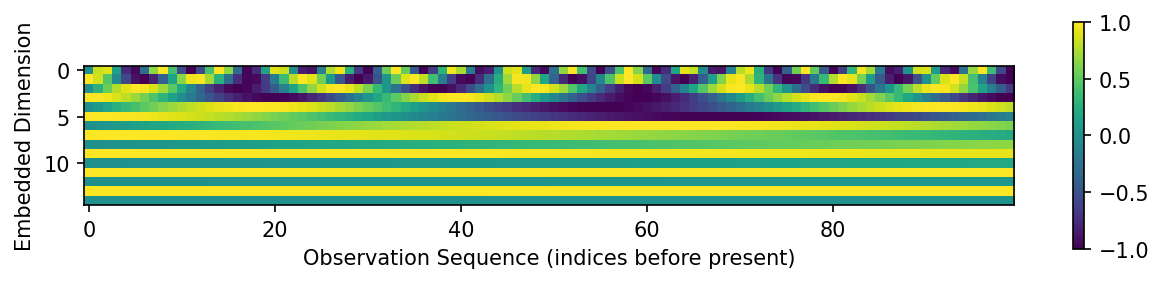

In [ ]:
##########################################################################################
# 4a) model pre-requisites
##########################################################################################
def ian_generate_positional_encoding(src):
  # src = X_cat0; d_model = 15

  pos_encoding = torch.zeros_like(src[0])
  seq_len = pos_encoding.shape[0]
  d_model = pos_encoding.shape[1]

  for i in range(d_model):
    for pos in range(seq_len):
      if i % 2 == 0:
        pos_encoding[pos,i] = np.sin(pos/100**(2*i/d_model))
      else:
        pos_encoding[pos,i] = np.cos(pos/100**(2*i/d_model))
  # plt.imshow(pos_encoding.cpu().numpy())
  return pos_encoding.float()

fig, ax = plt.subplots(figsize=[10,2])
im = ax.imshow(ian_generate_positional_encoding(torch.zeros(1,100,15)).T)
ax.set_xlabel("Observation Sequence (indices before present)")
ax.set_ylabel("Embedded Dimension")
fig.colorbar(im,ax=ax)

In [ ]:
##########################################################################################
# 4b) Transformer Model
##########################################################################################
class Soccer_Model_3ze(nn.Module):
    def __init__(self):  #pick up all specification vars from the global environment
        super(Soccer_Model_3ze, self).__init__() 
        self.emb = nn.Embedding(num_action_cats,cat_embedding_dim,padding_idx=act_padding_idx,scale_grad_by_freq=scale_grad_by_freq)
        self.lin0 = nn.Linear(num_contvars_in,cont_embedding_dim,bias=True)
        if model_type == "Transformer":
          #self.msk = torch.nn.Transformer.generate_square_subsequent_mask(self,maxlen-1).to(device)
          self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,nhead=transformer_nhead,batch_first=True,dim_feedforward=dim_feedforward).to(device)
          self.seqnet = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        if model_type == "ElmanRNN":
          self.seqnet =  nn.RNN(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True,nonlinearity=ElmanRNN_nonlinearity)
        if model_type == "LSTM":
          self.seqnet =  nn.LSTM(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True)
        if model_type == "GRU":
          self.seqnet =  nn.LSTM(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True)

        if model_type == "Transformer":
          self.lin1 = nn.Linear(d_model,transformer_finaldenselayer_dim)
        elif bidirectional:
          self.lin1 = nn.Linear(dim_feedforward*2,transformer_finaldenselayer_dim)
        else:
          self.lin1 = nn.Linear(dim_feedforward,transformer_finaldenselayer_dim)
        self.lin2 = nn.Linear(transformer_finaldenselayer_dim, num_action_cats + num_contvars_out,bias=True)
        print(self)        

    def forward(self, X):
        global testX, X_cat_seqnet
        testX = X
        #X = testX
        X_acts = X[:,:,0].int()
        X_actsemb = self.emb(X_acts)
        X_cont = X[:,:,1:]
        X_cont = self.lin0(X_cont.float())
              
        X_cat = torch.cat([X_actsemb,X_cont],dim=2)
        X_cat = X_cat.float()

        src = X_cat + ian_generate_positional_encoding(X_cat).to(device)
        if model_type == "Transformer":
          X_cat_seqnet = self.seqnet(src)
        else:
          X_cat_seqnet,_ = self.seqnet(src)

        out = self.lin1(X_cat_seqnet[:,-1,:])
        out = F.relu(out)
        out = self.lin2(out)
        return out

def Soccer_Model_3_lossfn_3ze(X, Yhat, Y, cat_weight=5.,cont_weight=1.):
        global testX, testYhat, testY
        testX, testYhat, testY = X, Yhat,Y
        #X, Yhat,Y = testX, testYhat, testY
                
        Y_acts = Y[:,0].long()
        Yminus1_acts = X[:,-1,0].long()
        Y_cont = Y[:,1:].float()

        Yhat_acts = Yhat[:,:num_chars]          #; Yhat_acts.shape  #10/13
        Yhat_cont = Yhat[:,num_chars:].float()  #; Yhat_cont.shape  #10/5
        #Yhat_cont = torch.clamp(Yhat_cont,min=0,max=1)   #clamp the cont RVs to the range [0,1]

        CEL = nn.CrossEntropyLoss(weight=weights.to(device),reduction="none")
        #MSEL = nn.MSELoss(reduction="none")
        #MSEL = nn.L1Loss(reduction="none")
        #MSEL = nn.MSELoss(reduction="none")

        Yhat_CEL  = torch.mean(CEL(Yhat_acts,Y_acts)) * cat_weight #/ torch.std(CEL(Yhat_acts,Y_acts))
        #Yhat_MSEL = MSEL(Yhat_cont,Y_cont.float())**2
        Yhat_MSEL= (Yhat_cont-Y_cont.float())**2
        #Yhat_MSEL[Yhat_MSEL > 0.15] = 100
        # Yhat_MSEL = Yhat_MSEL * torch.Tensor([0,0,1,0]).to(device)     
        # Yhat_MSEL = Yhat_MSEL * torch.Tensor([0,0,1,0]).to(device)       
        #target_vars   #['act', 's', 'deltax0', 'deltay0', 'deltaT']
        #Yhat_MSEL= abs(Yhat_cont-Y_cont.float())
        
        
        idx_ignorecurrent = torch.logical_or(Y_acts == 0, Y_acts == 1)             #idx2char # 0 @, 1_ #IS THE CURRENT ACTION ONE TO IGNORE?
        idx_ignoreminus1  = torch.logical_or(Yminus1_acts == 0, Yminus1_acts == 1) #idx2char # 0 @, 1_ #IS THE CURRENT ACTION ONE TO IGNORE BASED ON ACTION BEFORE?
        idx_ignore = torch.logical_or(idx_ignorecurrent,idx_ignoreminus1)
        if torch.sum(idx_ignore) == 0:    #if nothing to ignore...
          Yhat_MSEL = torch.mean(Yhat_MSEL)**(1/2) * cont_weight
        elif torch.sum(~idx_ignore) == 0:   #if everything to be ignored...
          #print("ignoring all MSEL")
          Yhat_MSEL = torch.Tensor([0.]).to(device)
        else:
          Yhat_MSEL = Yhat_MSEL[~idx_ignore,:]        
          Yhat_MSEL = torch.mean(Yhat_MSEL)**(1/2) * cont_weight #/ torch.std(Yhat_MSEL)
          #Yhat_MSEL = torch.mean(Yhat_MSEL)**(1) * MSELweight #/ torch.std(Yhat_MSEL)
         
        Yhat_totL = Yhat_CEL + Yhat_MSEL
        #Yhat_totL = Yhat_MSEL
        return Yhat_totL, Yhat_CEL, Yhat_MSEL

In [ ]:
##########################################################################################
# 4b) DEFINE TRAINING AND VALIDATION CYCLES
##########################################################################################
def trn(dataloader, model, loss_fn, optimiser, scheduler, val):
  if val: 
    model.eval()     #turn training off if val
  else:
    model.train()    #turn training on if not val

  size = len(dataloader.dataset)
  loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean  = 0., 0., 0.
  for batch, (X, Y) in enumerate(dataloader):
      X, Y = X.to(device), Y.to(device)
      
      pred = model(X)

      loss, lossCEL, lossMSE = loss_fn(X, pred, Y)
      loss_rollingmean = loss_rollingmean+(loss-loss_rollingmean)/(1+batch)
      lossCEL_rollingmean = lossCEL_rollingmean+(lossCEL-lossCEL_rollingmean)/(1+batch)
      lossMSE_rollingmean = lossMSE_rollingmean+(lossMSE-lossMSE_rollingmean)/(1+batch)

      if np.logical_not(val):
        # Backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

      if batch % 500 == 0:
        loss, current = loss.item(), batch * X.shape[0]
        print(f"trn loss: {loss:>7f}, ln(1+loss): {np.log(1+loss):>7f} | CEloss: {lossCEL:>7f}, MSEloss: {lossMSE} | batch: {batch} | sample: [{current:>5d}/{size:>5d}] | lr: {optimiser.param_groups[0]['lr']}")
  loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean  = loss_rollingmean.detach().cpu().numpy().item(), lossCEL_rollingmean.detach().cpu().numpy().item(), lossMSE_rollingmean.detach().cpu().numpy().item()  
  print(f"Epoch loss:    mean: {loss_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+loss_rollingmean):>7f}")
  print(f"Epoch CEloss:  mean: {lossCEL_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+lossCEL_rollingmean):>7f}")
  print(f"Epoch MSEloss: mean: {lossMSE_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+lossMSE_rollingmean):>7f}")
  if val:
    scheduler.step(loss_rollingmean); print("scheduler.step performed after val loop")   #step scheduler if val
  return loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean

In [ ]:
def go():
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  torch.cuda.empty_cache(); import gc; gc.collect()

  #model = Soccer_Model_3ze(hidden_size=128,num_layers=1,cat_embedding_dim=num_chars,dropout=0.2).to(device)
  model = Soccer_Model_3ze().to(device)
  loss_fn    = Soccer_Model_3_lossfn_3ze
  #optimiser  = optim.RMSprop(model.parameters(),lr=0.01,eps=1e-16)
  optimiser  = optim.Adam(model.parameters(),lr=0.01,eps=1e-16)
  scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser,factor=.1,patience=3,verbose=True)

  #model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_20210730am_working_1GRU20210816star3"))

  loss_hist = pd.DataFrame(columns=["epoch","trn_L","trn_CEL","trn_MSEL","val_L","val_CEL","val_MSEL","tst_L","tst_CEL","tst_MSEL"])
  epochs=50
  for t in range(epochs):
      torch.cuda.empty_cache(); import gc; gc.collect()
      print(f"Epoch {t}\n-------------------------------")
      trainloss = trn(trn_loader, model, loss_fn, optimiser, scheduler,val=False)   #TRAIN - the important bit!!
      valloss = trn(val_loader, model, loss_fn, optimiser, scheduler,val=True)      #VALIDATION set evaluation

      epochloss = pd.DataFrame(np.concatenate((np.array([t]),np.asarray(trainloss),np.asarray(valloss),np.array(["","",""])))).T
      epochloss.columns = loss_hist.columns
      loss_hist = loss_hist.append(epochloss)
          
      fig, ax = plt.subplots(3,1,figsize=(4,2))
      ax[0].plot(range(len(loss_hist)),loss_hist["trn_L"].astype(float),color="black",lw=0.5); ax[0].plot(range(len(loss_hist)),loss_hist["val_L"].astype(float),color="red",lw=0.5); ax[0].set_title("Loss"); ax[0].grid(); ax[0].set_axisbelow(True)
      ax[1].plot(range(len(loss_hist)),loss_hist["trn_CEL"].astype(float),color="black",lw=0.5); ax[1].plot(range(len(loss_hist)),loss_hist["val_CEL"].astype(float),color="red",lw=0.5); ax[1].set_title("CELoss"); ax[1].grid(); ax[2].set_axisbelow(True)
      ax[2].plot(range(len(loss_hist)),loss_hist["trn_MSEL"].astype(float),color="black",lw=0.5); ax[2].plot(range(len(loss_hist)),loss_hist["val_MSEL"].astype(float),color="red",lw=0.5); ax[2].set_title("MSELoss"); ax[2].grid(); ax[2].set_axisbelow(True)
      plt.show()

      # if t % 10 == 0:
      # #if t == 1:
      #   view_sample(model,t,dmo_loader)
      #   date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
      #   torch.save(model.state_dict(), f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_{date}") # hidden size 20, num_layers = 10
      #   #model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_20210730am_working_1"))
      if optimiser.param_groups[0]["lr"] < 1E-7:
        break
  date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
  torch.save(model.state_dict(), f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_{date}")
  torch.cuda.empty_cache(); import gc; gc.collect()
  view_sample(model,t,dmo_loader)
  print("Calculating test loss")
  tstloss = trn(tst_loader, model, loss_fn, optimiser, scheduler, val=True)
  epochloss = pd.DataFrame(np.concatenate((np.array([t]),np.array(["","","","","",""]),np.asarray(tstloss)))).T
  epochloss.columns = loss_hist.columns
  loss_hist = loss_hist.append(epochloss)
  final_loss = np.append(np.append(trainloss,valloss),tstloss)
  return final_loss

In [ ]:
##########################################################################################
# 4d) TRAIN!
##########################################################################################
num_action_cats = num_chars
act_padding_idx = 1
cat_embedding_dim = num_chars
scale_grad_by_freq = True
num_contvars_in  = len(input_vars) - 1
num_contvars_out = len(target_vars) - 1
cont_embedding_dim = num_contvars_in
d_model = cat_embedding_dim + cont_embedding_dim
transformer_nhead = 1
num_layers = 6
dim_feedforward = 16
transformer_finaldenselayer_dim = 64
#print(transformer_input_dim)
ElmanRNN_nonlinearity = "relu"
bidirectional = False
#model_type = "Transformer"
model_type = "GRU"

from datetime import datetime
all_loss = np.empty((0,14))



# for cat_embedding_dim in [7]:
#   for cont_embedding_dim in [9]:
#     for num_layers in [1,2,5]:
#       for dim_feedforward in [8,16,4096]:


for cat_embedding_dim in [7]:
  for cont_embedding_dim in [10]:
    for num_layers in [1]:
      for dim_feedforward in [8]:
        for model_type in ["Transformer"]:
          if model_type == "Transformer":
            for transformer_nhead in [1]:
              d_model = cat_embedding_dim + cont_embedding_dim
              final_loss = go()
              config = np.array([cat_embedding_dim,cont_embedding_dim,num_layers,dim_feedforward,model_type])
              all_loss = np.vstack((all_loss,np.hstack((config,final_loss))))
              date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
              np.savetxt(f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/model_res_{date}.csv",all_loss,delimiter=",",fmt='%s')
          else:
            for bidirectional in [True, False]:
              d_model = cat_embedding_dim + cont_embedding_dim
              final_loss = go()
              config = np.array([cat_embedding_dim,cont_embedding_dim,num_layers,dim_feedforward,model_type])
              all_loss = np.vstack((all_loss,np.hstack((config,final_loss))))
              date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
              np.savetxt(f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/model_res_{date}.csv",all_loss,delimiter=",",fmt='%s')

Soccer_Model_3ze(
  (emb): Embedding(7, 7, padding_idx=1, scale_grad_by_freq=True)
  (lin0): Linear(in_features=10, out_features=10, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
    )
    (linear1): Linear(in_features=17, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=17, bias=True)
    (norm1): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (seqnet): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
        )
        (linear1): Linear(in_

KeyboardInterrupt: ignored

In [ ]:
##########################################################################################
# 10) USE TRAINED MODEL TO MAKE PREDICTIONS ON WHOLE DATASET
##########################################################################################
##########################################################################################
# 10a) Make predictions
##########################################################################################
dataloader = DataLoader(dis_dataset,shuffle=False,batch_size=50,num_workers=2)
model = Soccer_Model_3ze().to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_2021_08_25-205146_CONFIG-Trf-31"))
model.eval()                     #turn training off if not already
i = 0
for batch, (X, Y) in enumerate(dataloader):
    # X, Y = X.to(device), Y.to(device)
    X = X.to(device)
    pred = model(X)
    # loss, lossCEL, lossMSE = loss_fn(pred, Y, CELweight, MSELweight)
    if i == 0:
      all_pred = pred
    else:
      all_pred = torch.cat((all_pred,pred))
    i+=1
    print(f"{i}/{len(dataloader.dataset)/dataloader.batch_size}")

all_pred = all_pred.detach().cpu().numpy()
#np.save("/content/gdrive/MyDrive/COMP6200project/Soccer/Predictions/all_pred_2508.npy", all_pred)
# np.savetxt("/content/gdrive/MyDrive/COMP6200project/Soccer/Predictions/all_pred_star3.csv", all_pred, delimiter=",")
# np.save("/content/gdrive/MyDrive/COMP6200project/Soccer/Predictions/all_pred_star3.npy", all_pred)
all_pred = np.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Predictions/all_pred_2508.npy")

##########################################################################################
# 10b) Append predictions to original data
##########################################################################################
dfpred = df.copy(deep=True)


colnames = list(idx2char.values())
colnames.extend(target_vars[1:])
colnames = ["pred_" + x for x in colnames]
colnames[5] = 'pred_acts'

from scipy.special import softmax
all_pred[:len(idx2char),:] = softmax(all_pred[:len(idx2char),:])
pred_act = np.vectorize(idx2char.get)(np.argmax(all_pred[:,:len(idx2char)],axis=1))
pred_act = np.array(pred_act).reshape(len(np.array(pred_act)),1)
start_nullacts = np.repeat("@",maxlen).reshape(maxlen,1)
# end_nullacts = np.repeat("@",(len(dfpred)-maxlen-len(all_pred)).reshape((len(dfpred)-maxlen-len(all_pred),1)
pred_act = np.concatenate((start_nullacts,pred_act))
pred_act = pd.DataFrame(pred_act,columns=["pred_act"])

start_zeros = np.zeros((maxlen,np.shape(all_pred)[1]))
end_zeros = np.zeros((len(dfpred)-maxlen-len(all_pred),np.shape(all_pred)[1]))
pred_to_append = np.concatenate((start_zeros,all_pred,end_zeros))

pred_to_append = pd.DataFrame(pred_to_append,columns=colnames)
pred_to_append = pd.concat([pred_to_append,pred_act],axis=1)




dfpred['act'].replace(idx2char,inplace=True)
dfpred = pd.concat([dfpred, pred_to_append], axis=1)
#dfpred.to_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Predictions/dfpred_star3.csv")   ######!!! start again here...
#dfpred = pd.read_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Predictions/dfpred_star3.csv")

dfDIS = dfpred.iloc[100:,:]
dfTRN = dfpred.loc[idx_trn,:].loc[100:,:]
dfVAL = dfpred.loc[idx_val,:].loc[100:,:]
dfTST = dfpred.loc[idx_tst,:].loc[100:,:]
dfDMO = dfpred.loc[idx_dmo,:].loc[100:,:]

In [ ]:
dfDIS = dfDIS.reset_index(drop=True)
print(dfDIS.columns)
cls = list(dfDIS.columns)
print(cls[23],cls[24])
cls[23] = "pred_x"
cls[24] = "pred_x0"
print(cls[23],cls[24])
dfDIS.columns = cls

idx0 = np.logical_or(dfDIS["act"].to_numpy()=="_",dfDIS["act"].to_numpy()=="@")
idx1 = np.append(False,idx0[:-1])
idx_ignore = np.logical_or(idx0,idx1)

dfDISi = dfDIS.loc[np.logical_not(idx_ignore),:]
dfDISi = dfDISi.reset_index(drop=True)

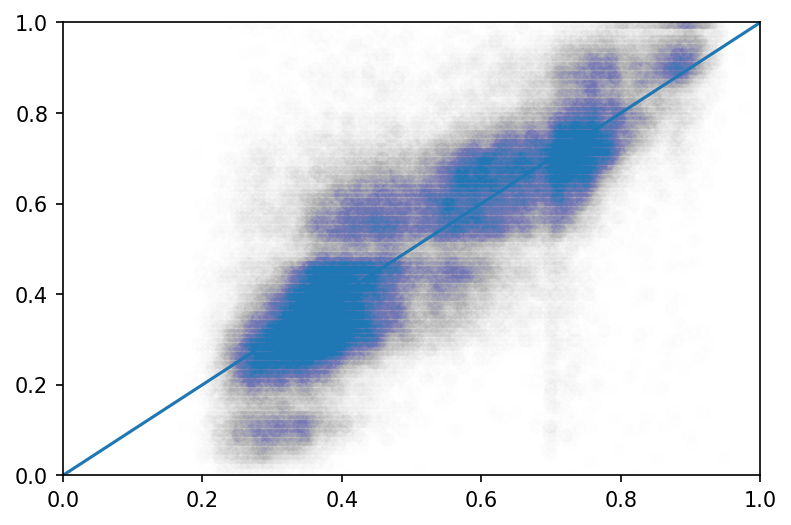

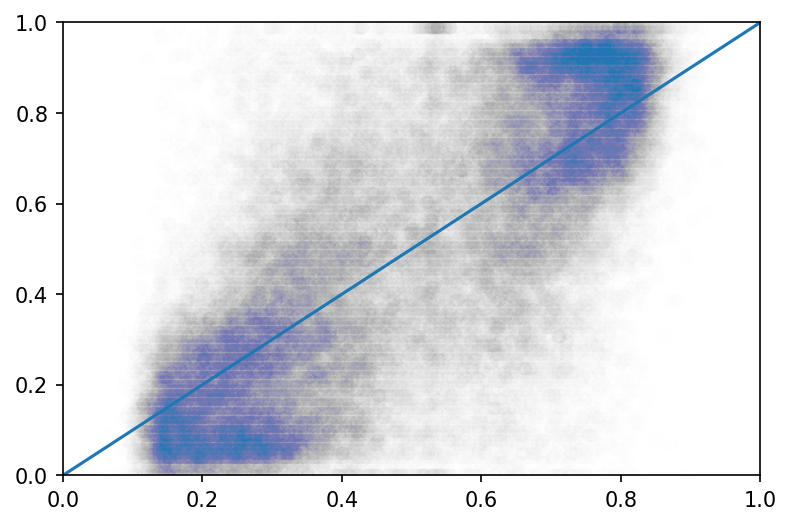

In [ ]:
fig, ax = plt.subplots()
ax.scatter(dfDISi["pred_x0"],dfDISi["x"],alpha=0.004)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0,1],[0,1])
plt.show()

fig, ax = plt.subplots()
ax.scatter(dfDISi["pred_y"],dfDISi["y"],alpha=0.004)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0,1],[0,1])
plt.show()

fig, ax = plt.subplots()
ax.scatter(dfDISi["pred_y"],dfDISi["y"],alpha=0.004)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0,1],[0,1])
plt.show()

In [ ]:
#Setup a soccer plot
def setup_soccerplot(include_labels=True,figsize=(8,5),xlim_max=1.1,bgcolor="darkgrey"):
  fig, ax = plt.subplots(figsize=figsize)
  #ax.grid(); ax.set_axisbelow(True)
  #ax.set_facecolor("#7a7a7a")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_xlim(-.1,xlim_max)
  ax.set_ylim(-.1,1.1)
  ax.set_xticks(np.arange(0, 1.01, step=0.1))
  ax.set_yticks([ 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
  ax.plot([0,1,1,0,0],[0,0,1,1,0],color="black")
  ax.plot([.5,.5],[0,1],color="black")

  ax.plot([0,.16,.16,0,0],[.19,.19,.81,.81,.19],color="black")
  ax.plot([0,.06,.06,0,0],[.37,.37,.63,.63,.37],color="black")

  ax.add_patch(mpatches.Rectangle((0,.19),.16,.62,fill=True,color=bgcolor,zorder=-1))
  ax.add_patch(mpatches.Rectangle((.84,.19),.16,.62,fill=True,color=bgcolor,zorder=-1))
  ax.plot([1,.84,.84,1,1],[.19,.19,.81,.81,.19],color="black")
  ax.plot([1,.94,.94,1,1],[.37,.37,.63,.63,.37],color="black")
  import matplotlib
  ax.add_patch(matplotlib.patches.Ellipse((0.115,.50),.18,.28,fill=False,zorder=-2))
  ax.add_patch(matplotlib.patches.Ellipse((.885,.50),.18,.28,fill=False,zorder=-2))
  ax.add_patch(matplotlib.patches.Ellipse((.50,.50),.13,.20,fill=False))
  ax.add_patch(mpatches.Rectangle((0,0),1,1,fill=True,color=bgcolor,zorder=-3))

  ax.scatter(.11,.50,zorder=2,color="black",s=2)
  ax.scatter(.89,.50,zorder=2,color="black",s=2)
  ax.scatter(0,.55,zorder=2,color="black",s=7)
  ax.scatter(0,.45,zorder=2,color="black",s=7)
  ax.scatter(1,.55,zorder=2,color="black",s=7)
  ax.scatter(1,.45,zorder=2,color="black",s=7)
  ax.scatter(.50,.50,zorder=2,color="black",s=7)

  if include_labels:
    ax.text(0,-.02,verticalalignment='top',horizontalalignment='left',fontsize=8,s="Offense direction →",color="black")
  return fig, ax

AxesSubplot(0.0390741,0.561111;0.149225x0.398222)
AxesSubplot(0.236574,0.561111;0.149225x0.398222)
AxesSubplot(0.434074,0.561111;0.149225x0.398222)
AxesSubplot(0.631574,0.561111;0.149225x0.398222)
AxesSubplot(0.829074,0.561111;0.149225x0.398222)


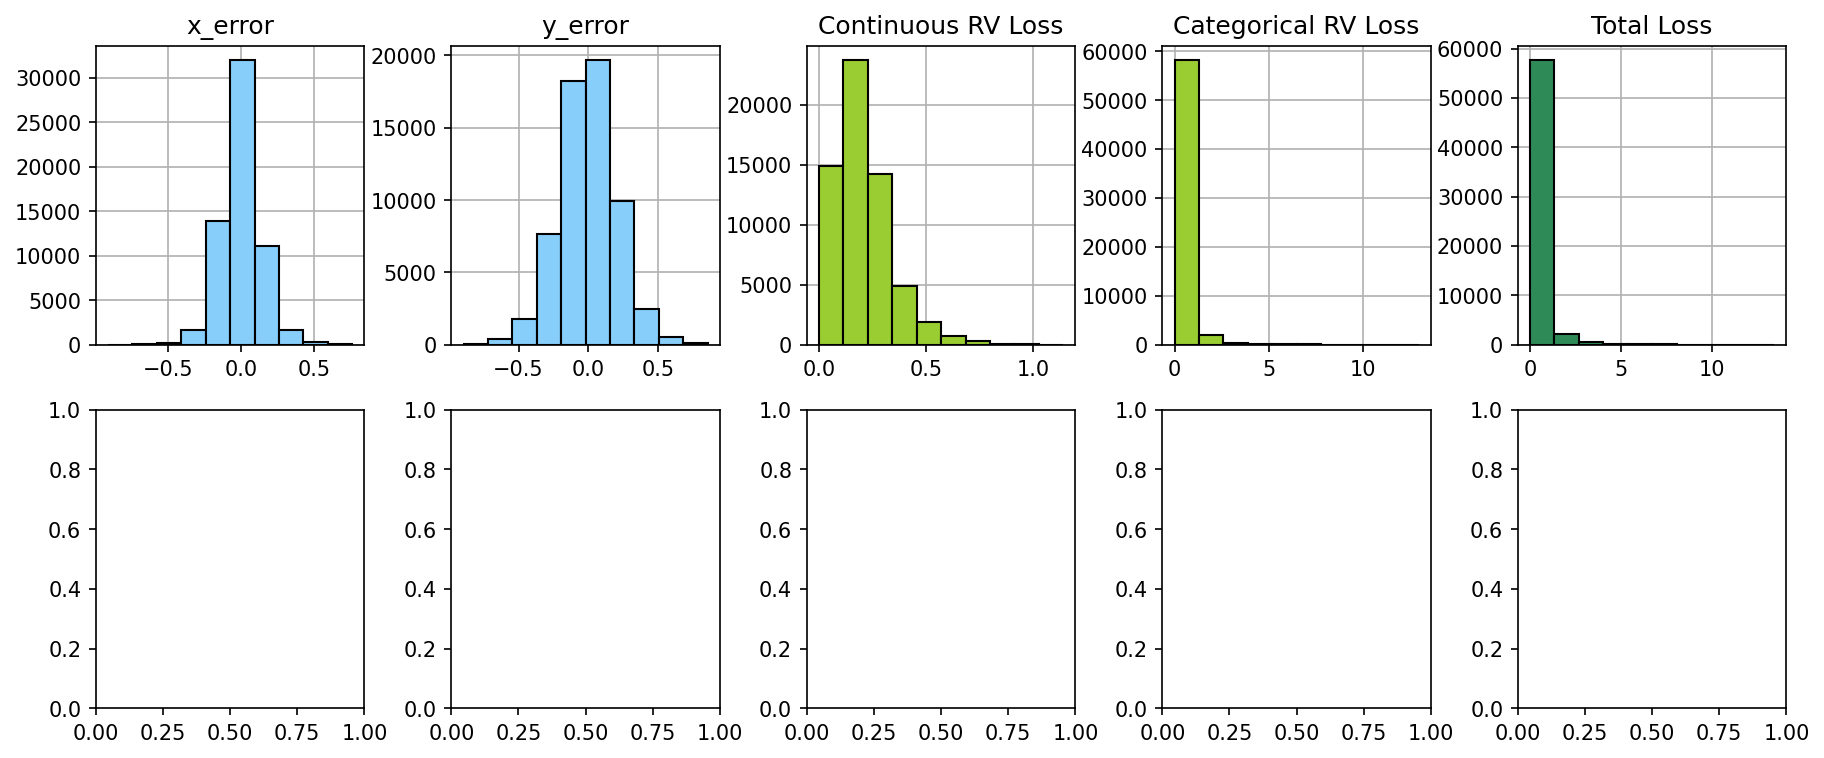

In [ ]:
temp0=dfDISi
#temp0=temp0.loc[temp0["act"]!=1,:]
#temp0=df

var = "y"
# fig, ax = plt.subplots(figsize=(3,3))
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
densmat = np.zeros((10,10))
temp1 = temp0
for i in range(10):
  for j in range(10):
    idx0 = np.logical_and(temp1["x"] > i/10,temp1["x"] <= (i+1)/10)
    idx1 = np.logical_and(temp1["y"] > j/10,temp1["y"] <= (j+1)/10)
    idx2 = np.logical_and(idx0,idx1)
    densmat[j,i] = np.mean(temp1.loc[idx2,"y"]-temp1.loc[idx2,"pred_y"])
densmat[9,9]=densmat[9,9]*0.9
fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
fig.colorbar(im,ax=ax)
ax.set_title("Variable y prediction error (y - y_pred) (n="+str(len(temp1))+")")
plt.show()

var = "x"
# fig, ax = plt.subplots(figsize=(3,3))
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
densmat = np.zeros((10,10))
temp1 = temp0
for i in range(10):
  for j in range(10):
    idx0 = np.logical_and(temp1["x"] > i/10,temp1["x"] <= (i+1)/10)
    idx1 = np.logical_and(temp1["y"] > j/10,temp1["y"] <= (j+1)/10)
    idx2 = np.logical_and(idx0,idx1)
    densmat[j,i] = np.mean(temp1.loc[idx2,"x"]-temp1.loc[idx2,"pred_x0"])
densmat[9,9]=densmat[9,9]*0.9
fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
fig.colorbar(im,ax=ax)
ax.set_title("Variable x prediction error (n="+str(len(temp1))+")")
plt.show()

# fig, ax = plt.subplots(figsize=(3,3))
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
densmat = np.zeros((10,10))
temp1 = temp0
for i in range(10):
  for j in range(10):
    idx0 = np.logical_and(temp1["x"] > i/10,temp1["x"] <= (i+1)/10)
    idx1 = np.logical_and(temp1["y"] > j/10,temp1["y"] <= (j+1)/10)
    idx2 = np.logical_and(idx0,idx1)
    densmat[j,i] = np.mean((temp1.loc[idx2,"x"]-temp1.loc[idx2,"pred_x0"])**2+(temp1.loc[idx2,"y"]-temp1.loc[idx2,"pred_y"])**2)**0.5
densmat[9,9]=densmat[9,9]*0.9
fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
fig.colorbar(im,ax=ax)
ax.set_title("Joint x,y prediction RMSE (n="+str(len(temp1))+")")
plt.show()

dfDISi["actnum"] = 0
dfDISi["CEL"] = 0.
dfDISi["RMSE"] = 0.
dfDISi["Loss"] = 0.
CEL = nn.CrossEntropyLoss(weight=weights,reduction="none")


act_str = dfDISi["act"].to_numpy(copy=True)
for key in char2idx:
  act_str[act_str==key] = char2idx[key]
dfDISi["actnum"] =act_str

for i in range(len(dfDISi)):
  if i % 1000 == 0: print(i)
  y           = dfDISi.iloc[i]["actnum"]
  y_pred      = dfDISi.iloc[i][17:24].to_numpy()
  y_pred_CEL  = CEL(torch.Tensor([y_pred]),torch.Tensor([y]).long()) * 5.
  dfDISi.at[i,"CEL"] = y_pred_CEL.numpy()

# np.sum(dfDISi["CEL"])
# np.mean(dfDISi["CEL"])

for i in range(len(dfDISi)):
  if i % 1000 == 0: print(i)
  y_pred_RMSE=((dfDISi.iloc[i]["x"]-dfDISi.iloc[i]["pred_x0"])**2+
              (dfDISi.iloc[i]["y"]-dfDISi.iloc[i]["pred_y"])**2)**0.5
  dfDISi.at[i,"RMSE"] = y_pred_RMSE

dfDISi["Loss"] = dfDISi["CEL"] + dfDISi["RMSE"]

dfDISi["x_error"] = dfDISi["x"]-dfDISi["pred_x0"]
dfDISi["y_error"] = dfDISi["y"]-dfDISi["pred_y"]


fig, ax = plt.subplots(2,5,figsize=(12,5))
fig.tight_layout()
vars = ["x_error","y_error","RMSE","CEL","Loss"]
titles = ["x_error","y_error","Continuous RV Loss","Categorical RV Loss","Total Loss"]
colors = ['lightskyblue', 'lightskyblue', 'yellowgreen', 'yellowgreen', 'seagreen']
for i in range(len(vars)):
  tax = ax[int(i/5),i%5]
  print(tax)
  tax.hist(dfDISi[vars[i]],color=colors[i],ec="black")
  tax.grid()
  tax.set_axisbelow(True)
  tax.set_title(titles[i])



# np.sum(dfDISi["RMSE"])
# np.mean(dfDISi["RMSE"])

# for var in ['T', 'deltaT', 'x', 'y', 's', 'scrad', 'deltax', 'deltay', 'sg','thetag']:
#   fig, ax = plt.subplots(figsize=(3,3))
#   #var = "thetag"
#   ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
#   densmat = np.zeros((10,10))
#   tempdf = df
#   for i in range(10):
#     for j in range(10):
#       idx0 = np.logical_and(tempdf["x"] > i/10,tempdf["x"] <= (i+1)/10)
#       idx1 = np.logical_and(tempdf["y"] > j/10,tempdf["y"] <= (j+1)/10)
#       idx2 = np.logical_and(idx0,idx1)
#       densmat[j,i] = np.mean(tempdf.loc[idx2,var])
#   ax.imshow(densmat)
#   plt.show()

# for var in ['T', 'deltaT', 'x', 'y', 's', 'scrad', 'deltax', 'deltay', 'sg','thetag']:
#   fig, ax = plt.subplots(figsize=(3,3))
#   ax.set_title(var)
#   ax.hist(df[var])
#   plt.show()

#plt.scatter(df.loc[df["act"]=="g","x"],df.loc[df["act"]=="g","y"])

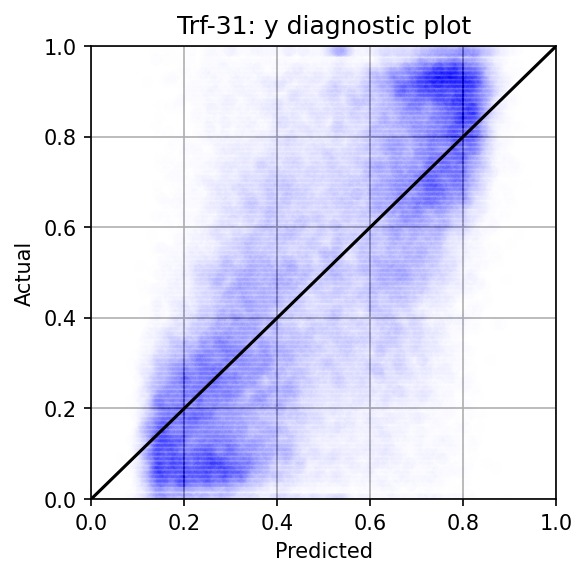

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(); ax.set_axisbelow(True)
pred = dfDISi["pred_x0"]
act  = dfDISi["x"]
ax.scatter(pred,act,color="blue",alpha=0.005,edgecolor='none')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Trf-31: x diagnostic plot")
ax.plot([0,1],[0,1],color="black")
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
ax.grid(); ax.set_axisbelow(True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
pred = dfDISi["pred_y"]
act  = dfDISi["y"]
ax.scatter(pred,act,color="blue",alpha=0.005,edgecolor='none')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Trf-31: y diagnostic plot")
ax.plot([0,1],[0,1],color="black")
plt.show()




dfDISi2 = dfDISi
dfDISi2["x_minus1"] = 0.
dfDISi2["x_minus1"][1:] = dfDISi2["x"][:-1]
dfDISi2["y_minus1"] = 0.
dfDISi2["y_minus1"][1:] = dfDISi2["y"][:-1]
idx0 = dfDISi2["act"]!="_"
idx1 = np.append(True,idx0[:-1])
idx = np.logical_or(idx0,idx1)
dfDISi2 = dfDISi2.loc[idx,:]
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(); ax.set_axisbelow(True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
pred = dfDISi2["y_minus1"]
act  = dfDISi2["y"]
ax.scatter(pred,act,color="blue",alpha=0.005,edgecolor='none')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Lag 1 baseline: y diagnostic plot")
ax.plot([0,1],[0,1],color="black")
plt.show()
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(); ax.set_axisbelow(True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
pred = dfDISi2["x_minus1"]
act  = dfDISi2["x"]
ax.scatter(pred,act,color="blue",alpha=0.005,edgecolor='none')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Lag 1 baseline: x diagnostic plot")
ax.plot([0,1],[0,1],color="black")
plt.show()



fig, ax = plt.subplots(figsize=(4,4))
ax.grid(); ax.set_axisbelow(True)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_yticks([-1,-.5,0,.5,1])
ax.set_xticks([-1,-.5,0,.5,1])
pred = dfDISi2["y"]-dfDISi2["pred_y"]
act  = dfDISi2["y"]-dfDISi2["y_minus1"]
ax.scatter(pred,act,color="blue",alpha=0.008,edgecolor='none')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Trf-31: y_t-y_{t-1}")
ax.plot([-1,1],[-1,1],color="black")
plt.show()


fig, ax = plt.subplots(figsize=(4,4))
ax.grid(); ax.set_axisbelow(True)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_yticks([-1,-.5,0,.5,1])
ax.set_xticks([-1,-.5,0,.5,1])
pred = dfDISi2["x"]-dfDISi2["pred_x0"]
act  = dfDISi2["x"]-dfDISi2["x_minus1"]
ax.scatter(pred,act,color="blue",alpha=0.008,edgecolor='none')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Trf-31: x_t-x_{t-1}")
ax.plot([-1,1],[-1,1],color="black")
plt.show()


In [ ]:
dfDISi

,comp,TID,MID,index,PID,act,T,x,y,sg,thetag,scrad,deltaT,deltax,deltay,s,valid_slice_flag,pred_@,pred__,pred_d,pred_g,pred_p,pred_acts,pred_x,pred_x0,pred_y,pred_act,actnum,CEL,RMSE,Loss,x_error,y_error,x_minus1,y_minus1
0,ES,676,2565681,1157435,223504,p,0.104295,0.64,0.039604,0.490812,0.560796,0.521538,0.512313,0.490,0.495,0.022053,True,-48.580910,-48.252243,0.383609,-48.229507,0.311585,-1.126647,-0.004946,0.586785,0.151670,d,4,0.072286,0.124059,0.196345,0.053215,-0.112066,0.00,0.000000
1,ES,676,2565681,1157436,223504,p,0.105736,0.65,0.722772,0.397497,0.752644,0.521538,0.805720,0.505,0.845,0.464673,True,-48.300865,-47.978065,0.387356,-47.952412,0.319583,-1.108777,-0.036807,0.584171,0.162418,d,4,0.071627,0.564207,0.635834,0.065829,0.560354,0.64,0.039604
2,ES,676,2565681,1157460,223506,p,0.117243,0.47,0.287129,0.575018,0.839729,0.521538,0.406144,0.665,0.480,0.347545,True,-58.541130,-58.036800,1.168193,-58.053635,1.199547,-2.184455,-1.996544,0.275668,0.377111,p,4,0.046468,0.214154,0.260622,0.194332,-0.089982,0.65,0.722772
3,ES,676,2565681,1157472,223508,p,0.122535,0.07,0.306931,0.985286,0.916809,0.521538,0.512313,0.370,0.215,0.470959,True,-56.511688,-56.097836,1.211555,-56.134632,1.088654,-2.163247,-0.800108,0.394754,0.769348,d,4,0.054722,0.565062,0.619784,-0.324754,-0.462418,0.47,0.287129
4,ES,676,2565681,1157482,223510,p,0.125710,0.36,0.158416,0.711011,0.789764,0.521538,0.267011,0.525,0.560,0.096351,True,-58.665405,-58.150604,0.947184,-58.184090,0.915806,-2.091473,-1.235643,0.373389,0.227107,d,4,0.051179,0.069984,0.121164,-0.013389,-0.068692,0.07,0.306931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60764,FR,19830,2500961,1953614,374281,d,0.928554,0.72,0.613861,0.304024,0.837794,0.839473,0.453975,0.525,0.605,0.150819,True,-35.034027,-35.001564,-0.295428,-34.863377,-0.620162,0.528037,0.082079,0.728236,0.407303,s,2,1.018441,0.206722,1.225163,-0.008236,0.206558,0.79,0.603960
60765,FR,19830,2500961,1953672,374295,d,0.966200,0.45,0.851485,0.625006,0.751737,0.839473,0.570139,0.495,0.685,0.249330,True,-42.081944,-41.909718,0.619440,-41.822174,0.627468,-0.812320,-0.782610,0.506483,0.595645,p,2,0.548102,0.262001,0.810103,-0.056483,0.255841,0.72,0.613861
60766,FR,19830,2500961,1953682,374299,p,0.974295,0.51,0.386139,0.520293,0.906780,0.839473,0.317181,0.625,0.340,0.339592,True,-53.203735,-52.830471,1.110048,-52.822075,1.090795,-1.835187,-1.414238,0.356184,0.649468,d,4,0.049898,0.304962,0.354860,0.153816,-0.263330,0.45,0.851485
60767,FR,19830,2500961,1953687,374301,p,0.974755,0.33,0.435644,0.704860,0.962433,0.839473,0.299179,0.545,0.410,0.153678,True,-54.091156,-53.698940,1.155919,-53.693581,1.148953,-1.913195,-1.586060,0.331583,0.638036,d,4,0.048801,0.202399,0.251200,-0.001583,-0.202393,0.51,0.386139


In [ ]:
cols = ["Actual"]
cols.extend(list(char2idx.keys()))
act_accuracy = pd.DataFrame(columns=cols)

for i in list(char2idx.keys()):
  k_row = np.array([i])
  
  i_preds = dfDISi["pred_act"][dfDISi["act"] == i]
  for j in list(char2idx.keys()):
    k_row = np.append(k_row,int(np.sum(i_preds == j)))

  k_row2 = pd.DataFrame(k_row).T
  k_row2.columns = cols

  act_accuracy = pd.concat([act_accuracy,k_row2],ignore_index=True)

print(act_accuracy)



  Actual  @  _      d  g      p     s     x
0      @  0  0      0  0      0     0     0
1      _  0  0      0  0      0     0     0
2      d  0  0   2589  0   1695   721  1537
3      g  0  0      5  0      0   125    56
4      p  0  0  24161  0  14160  3039  8414
5      s  0  0     75  0     38  1030   319
6      x  0  0    353  0     98   751  1603


In [ ]:
var = "d"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_"+var])

var = "p"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_"+var])

var = "s"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_act"+var])

var = "x"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_"+var])

0.4684263809984168

In [ ]:
import scipy
from scipy.special import softmax

var = "d"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_"+var])
smax = scipy.special.softmax(dfDISi.loc[idx,"pred_@":"pred_x"],axis=1)
print(np.mean(smax))

var = "p"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_"+var])
smax = scipy.special.softmax(dfDISi.loc[idx,"pred_@":"pred_x"],axis=1)
print(np.mean(smax))

var = "s"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_act"+var])
smax = scipy.special.softmax(dfDISi.loc[idx,"pred_@":"pred_x"],axis=1)
print(np.mean(smax))

var = "x"
idx = dfDISi["act"] == var
np.mean(dfDISi.loc[idx,"pred_"+var])
smax = scipy.special.softmax(dfDISi.loc[idx,"pred_@":"pred_x"],axis=1)
print(np.mean(smax))


pred_@       4.347294e-17
pred__       4.213967e-17
pred_d       3.484739e-01
pred_g       4.983569e-17
pred_p       3.220986e-01
pred_acts    1.339479e-01
pred_x       1.954797e-01
dtype: float64
pred_@       6.431983e-17
pred__       6.164974e-17
pred_d       3.826454e-01
pred_g       7.332739e-17
pred_p       3.611409e-01
pred_acts    9.525471e-02
pred_x       1.609590e-01
dtype: float64
pred_@       1.940797e-17
pred__       1.962861e-17
pred_d       1.151820e-01
pred_g       2.268777e-17
pred_p       7.137041e-02
pred_acts    5.410710e-01
pred_x       2.723766e-01
dtype: float64
pred_@       4.168952e-17
pred__       4.113657e-17
pred_d       1.854943e-01
pred_g       4.817107e-17
pred_p       1.295558e-01
pred_acts    2.855964e-01
pred_x       3.993535e-01
dtype: float64


In [ ]:
temp0=dfDISi3
#temp0=temp0.loc[temp0["pred_act"]=="d",:]
#temp0=df

# fig, ax = plt.subplots(figsize=(3,3))
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
# densmat = np.zeros((10,10))
# temp1 = temp0
# for i in range(10):
#   for j in range(10):
#     idx0 = np.logical_and(temp1["pred_x0"] > i/10,temp1["pred_x0"] <= (i+1)/10)
#     idx1 = np.logical_and(temp1["pred_y"] > j/10,temp1["pred_y"] <= (j+1)/10)
#     idx2 = np.logical_and(idx0,idx1)
#     densmat[j,i] = np.sum(idx2)
# #densmat[9,9]=densmat[9,9]
# fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
# im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
# fig.colorbar(im,ax=ax)
# ax.set_title(f"Trf-31: Action 'd' predicted (n="+str(len(temp1))+")")
# plt.show()

densmat = np.zeros((10,10))
temp1 = temp0.loc[temp0["k"]==0,:]
for i in range(10):
  for j in range(10):
    idx0 = np.logical_and(temp1["pred_x0"] > i/10,temp1["pred_x0"] <= (i+1)/10)
    idx1 = np.logical_and(temp1["pred_y"] > j/10,temp1["pred_y"] <= (j+1)/10)
    idx2 = np.logical_and(idx0,idx1)
    densmat[j,i] = np.mean(temp1.loc[idx2]["pred_d"]-temp1.loc[idx2]["pred_p"])
# densmat[4,1]=densmat[1,1]*0.8
# densmat[2,1]=densmat[1,1]*0.8
fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
fig.colorbar(im,ax=ax)
ax.set_title(f"Trf-31: Pred. prob. act 'd' minus act 'p' (n="+str(len(temp1))+")")
plt.show()

,Unnamed: 0,comp,TID,MID,index,PID,act,T,x,y,sg,thetag,scrad,deltaT,deltax,deltay,s,valid_slice_flag,pred_@,pred__,pred_d,pred_g,pred_p,pred_acts,pred_x,pred_x0,pred_y,pred_act,actnum,CEL,RMSE,Loss,x_error,y_error,x_minus1,y_minus1,attack_surprise,attack_surprise_lag3to1,attack_surprise_lag2to0,attack_surprise_lag3to0,attack_surprise_lag4to0,attack_surprise_lag5to0,attack_surprise_lag1to0,metric_dx,metric_dy,ASmetric,metric_as,k
42696,42696,EU,7047,1694414,1532724,294486,x,0.006768,0.96,0.960396,0.315874,0.085075,0.521538,0.750676,0.635,0.485,0.284219,False,3.784306e-21,4.584306e-21,0.339562,4.685739e-21,0.280997,0.054747,0.324695,0.628580,0.817138,d,6,1.631062,0.361057,1.992119,0.331420,0.143258,0.69,0.990099,0.620558,0.280549,0.184978,0.065031,0.076570,-0.010198,0.295414,0.331420,0.143258,0.964916,0.964916,0
42714,42714,EU,7047,1694414,1532781,294502,p,0.059138,0.48,0.792079,0.581002,0.779502,0.521538,0.752798,0.620,0.485,0.252808,False,1.080138e-27,1.768971e-27,0.495372,1.694900e-27,0.471829,0.010379,0.022421,0.275674,0.696214,d,4,0.048824,0.225697,0.274521,0.204326,0.095865,0.24,0.821782,-0.032799,-0.052153,-0.025983,-0.037558,-0.026901,-0.154396,-0.034277,0.204326,0.095865,0.577284,0.577284,0
42715,42715,EU,7047,1694414,1532782,294502,p,0.059437,0.48,0.881188,0.604404,0.719310,0.521538,0.418802,0.500,0.545,0.060594,False,1.231280e-22,1.626012e-22,0.442502,1.664571e-22,0.407787,0.043318,0.106393,0.480266,0.707698,d,4,0.058306,0.173491,0.231796,-0.000266,0.173491,0.48,0.792079,-0.149711,-0.091255,-0.061329,-0.056915,-0.039094,-0.137017,-0.083055,-0.000266,0.173491,0.621501,0.621501,0
42718,42718,EU,7047,1694414,1532785,294502,p,0.061249,0.34,0.930693,0.752345,0.746989,0.521538,0.677868,0.525,0.570,0.107892,True,3.087140e-26,4.769814e-26,0.486505,4.676915e-26,0.467337,0.015815,0.030344,0.318802,0.679960,d,4,0.049446,0.251627,0.301073,0.021198,0.250733,0.29,0.792079,-0.046158,-0.072710,-0.043899,-0.063666,-0.030492,-0.081458,-0.047894,0.021198,0.250733,0.800392,0.800392,0
42734,42734,EU,7047,1694414,1532815,294508,p,0.083170,0.32,0.584158,0.716290,0.951044,0.521538,0.255441,0.555,0.600,0.177403,True,3.231655e-26,5.192814e-26,0.470054,5.147570e-26,0.479560,0.021678,0.028709,0.318168,0.353615,p,4,0.047768,0.230550,0.278318,0.001832,0.230543,0.21,0.386139,-0.050387,-0.086481,-0.042699,-0.055803,-0.028090,-0.097328,-0.055837,0.001832,0.230543,0.741447,0.741447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43805,43805,EU,7047,1694419,1540092,295963,p,0.861027,0.54,0.306931,0.500525,0.832756,0.521538,0.770490,0.525,0.615,0.163509,True,1.374130e-23,2.000125e-23,0.406818,2.021541e-23,0.386193,0.057639,0.149350,0.516689,0.193841,d,4,0.061842,0.115467,0.177309,0.023311,0.113090,0.49,0.079208,-0.206989,-0.141940,-0.086962,-0.080854,-0.054127,-0.126651,-0.122717,0.023311,0.113090,0.650364,0.650364,0
43816,43816,EU,7047,1694419,1540116,295969,x,0.871590,0.95,0.198020,0.211952,0.159677,0.521538,0.645049,0.590,0.580,0.217544,True,1.071866e-19,1.317860e-19,0.235685,1.409372e-19,0.201951,0.099066,0.463298,0.718709,0.149555,x,6,1.115608,0.236314,1.351923,0.231291,0.048465,0.77,0.039604,0.437636,0.023540,0.037787,-0.081279,0.004824,-0.106135,0.121179,0.231291,0.048465,0.712189,0.712189,0
43818,43818,EU,7047,1694419,1540118,295969,s,0.878167,0.89,0.564356,0.123513,0.771018,0.521538,0.570139,0.445,0.785,0.400767,True,4.102146e-20,4.684387e-20,0.049385,5.092599e-20,0.019833,0.690266,0.240515,0.879517,0.382859,s,5,1.074965,0.181800,1.256765,0.010483,0.181498,1.00,0.000000,0.069219,0.051810,0.065276,0.056200,0.022952,-0.018235,0.043210,0.010483,0.181498,0.961000,0.961000,0
43839,43839,EU,7047,1694419,1540194,295989,x,0.942277,0.85,0.920792,0.326621,0.320993,0.199246,0.570139,0.570,0.525,0.150805,True,1.854212e-18,2.010065e-18,0.255351,2.154273e-18,0.210730,0.105064,0.428855,0.708018,0.770946,x,6,1.22

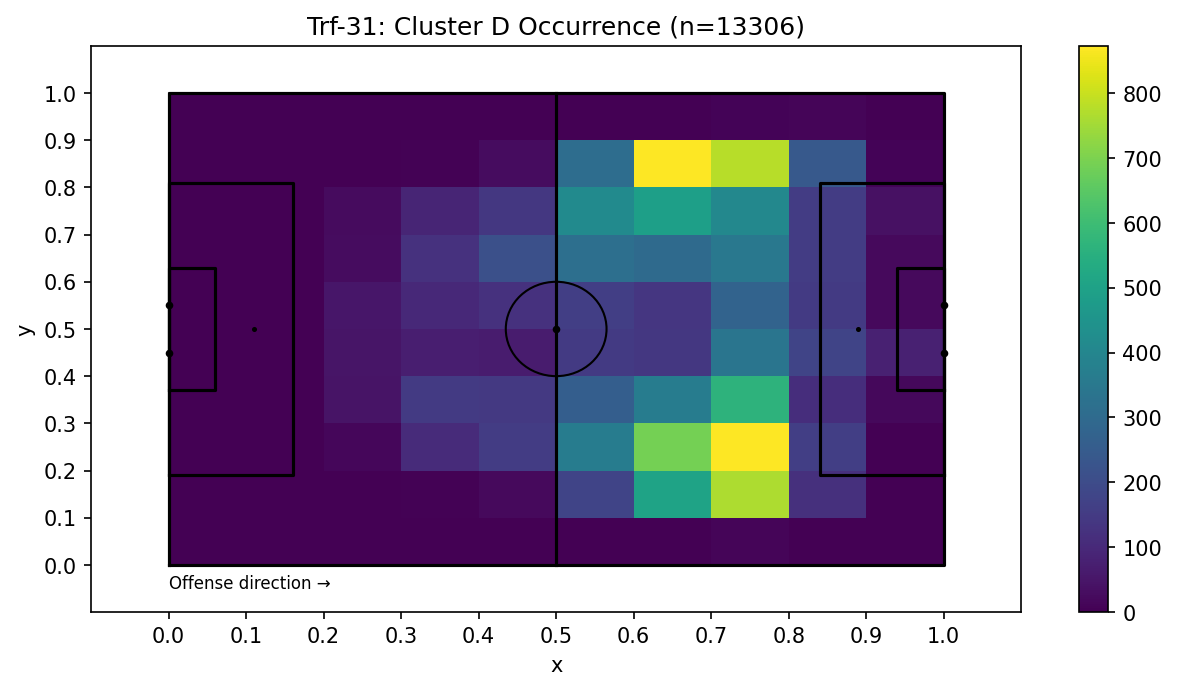

In [ ]:
temp0=dfDISi3
#temp0=temp0.loc[temp0["pred_act"]=="d",:]
#temp0=df

# fig, ax = plt.subplots(figsize=(3,3))
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
# densmat = np.zeros((10,10))
# temp1 = temp0
# for i in range(10):
#   for j in range(10):
#     idx0 = np.logical_and(temp1["pred_x0"] > i/10,temp1["pred_x0"] <= (i+1)/10)
#     idx1 = np.logical_and(temp1["pred_y"] > j/10,temp1["pred_y"] <= (j+1)/10)
#     idx2 = np.logical_and(idx0,idx1)
#     densmat[j,i] = np.sum(idx2)
# #densmat[9,9]=densmat[9,9]
# fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
# im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
# fig.colorbar(im,ax=ax)
# ax.set_title(f"Trf-31: Action 'd' predicted (n="+str(len(temp1))+")")
# plt.show()

densmat = np.zeros((10,10))
temp1 = temp0.loc[temp0["k"]==4,:]
for i in range(10):
  for j in range(10):
    idx0 = np.logical_and(temp1["pred_x0"] > i/10,temp1["pred_x0"] <= (i+1)/10)
    idx1 = np.logical_and(temp1["pred_y"] > j/10,temp1["pred_y"] <= (j+1)/10)
    idx2 = np.logical_and(idx0,idx1)
    densmat[j,i] = np.sum(idx2)
# densmat[4,1]=densmat[1,1]*0.8
# densmat[2,1]=densmat[1,1]*0.8
fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
fig.colorbar(im,ax=ax)
ax.set_title(f"Trf-31: Cluster D Occurrence (n="+str(len(temp1))+")")
plt.show()

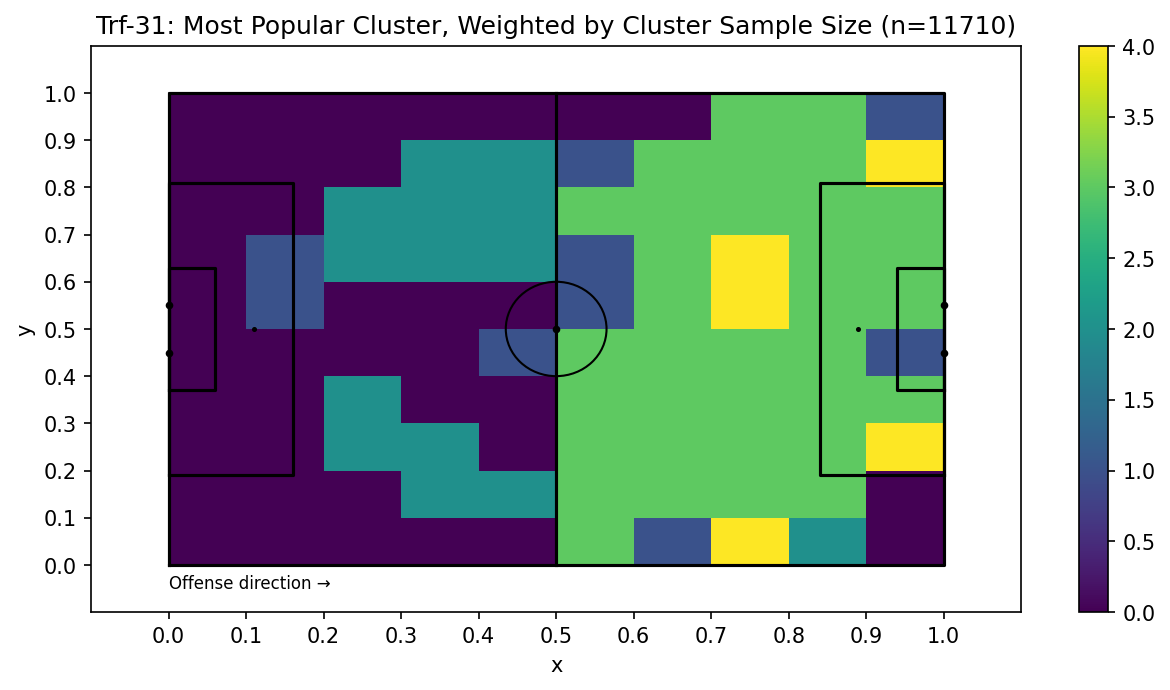

In [ ]:
temp0=dfDISi3
#temp0=temp0.loc[temp0["pred_act"]=="d",:]
#temp0=df

# fig, ax = plt.subplots(figsize=(3,3))
# ax.set_title(var); ax.set_ylabel("y"); ax.set_xlabel("x")
# densmat = np.zeros((10,10))
# temp1 = temp0
# for i in range(10):
#   for j in range(10):
#     idx0 = np.logical_and(temp1["pred_x0"] > i/10,temp1["pred_x0"] <= (i+1)/10)
#     idx1 = np.logical_and(temp1["pred_y"] > j/10,temp1["pred_y"] <= (j+1)/10)
#     idx2 = np.logical_and(idx0,idx1)
#     densmat[j,i] = np.sum(idx2)
# #densmat[9,9]=densmat[9,9]
# fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
# im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
# fig.colorbar(im,ax=ax)
# ax.set_title(f"Trf-31: Action 'd' predicted (n="+str(len(temp1))+")")
# plt.show()

densmats=[]

densmat = np.zeros((10,10))
temp1 = temp0.loc[temp0["k"]==2,:]
for i in range(10):
  for j in range(10):
    idx0 = np.logical_and(temp1["pred_x0"] > i/10,temp1["pred_x0"] <= (i+1)/10)
    idx1 = np.logical_and(temp1["pred_y"] > j/10,temp1["pred_y"] <= (j+1)/10)
    idx2 = np.logical_and(idx0,idx1)
    densmat[j,i] = np.sum(idx2)
densmats.append(densmat)


i,j=5,5
np.argmax(
np.array([densmats[0][i,j]/9666,
          densmats[1][i,j]/13445,
          densmats[2][i,j]/11710,
          densmats[3][i,j]/12642,
          densmats[4][i,j]/13306]))

densmat = np.zeros((10,10))
for i in range(10):
  for j in range(10):
    densmat[i,j] = np.argmax(
                      np.array([densmats[0][i,j]/9666,
                                densmats[1][i,j]/13445,
                                densmats[2][i,j]/11710,
                                densmats[3][i,j]/12642,
                                densmats[4][i,j]/13306]))




# densmat[4,1]=densmat[1,1]*0.8
# densmat[2,1]=densmat[1,1]*0.8
fig, ax = setup_soccerplot(include_labels=True,bgcolor="dimgrey",figsize=(10,5))
im = ax.imshow(densmat,extent=[0,1,0,1],aspect="auto")
fig.colorbar(im,ax=ax)
ax.set_title(f"Trf-31: Most Popular Cluster, Weighted by Cluster Sample Size (n="+str(len(temp1))+")")
plt.show()

,comp,TID,MID,index,PID,act,T,x,y,sg,thetag,scrad,deltaT,deltax,deltay,s,valid_slice_flag,pred_@,pred__,pred_d,pred_g,pred_p,pred_acts,pred_x,pred_x0,pred_y,pred_act,actnum,CEL,RMSE,Loss,x_error,y_error,x_minus1,y_minus1
0,ES,676,2565681,1157435,223504,p,0.104295,0.64,0.039604,0.490812,0.560796,0.521538,0.512313,0.490,0.495,0.022053,True,1.919931e-22,2.667005e-22,0.353432,2.728335e-22,0.328872,0.078057,0.239640,0.586785,0.151670,d,4,0.072286,0.124059,0.196345,0.053215,-0.112066,0.00,0.000000
1,ES,676,2565681,1157436,223504,p,0.105736,0.65,0.722772,0.397497,0.752644,0.521538,0.805720,0.505,0.845,0.464673,True,2.545879e-22,3.515830e-22,0.355520,3.607191e-22,0.332223,0.079634,0.232623,0.584171,0.162418,d,4,0.071627,0.564207,0.635834,0.065829,0.560354,0.64,0.039604
2,ES,676,2565681,1157460,223506,p,0.117243,0.47,0.287129,0.575018,0.839729,0.521538,0.406144,0.665,0.480,0.347545,True,5.552390e-27,9.194065e-27,0.474143,9.040585e-27,0.489245,0.016591,0.020021,0.275668,0.377111,p,4,0.046468,0.214154,0.260622,0.194332,-0.089982,0.65,0.722772
3,ES,676,2565681,1157472,223508,p,0.122535,0.07,0.306931,0.985286,0.916809,0.521538,0.512313,0.370,0.215,0.470959,True,4.157806e-26,6.289239e-26,0.487248,6.062023e-26,0.430899,0.016676,0.065177,0.394754,0.769348,d,4,0.054722,0.565062,0.619784,-0.324754,-0.462418,0.47,0.287129
4,ES,676,2565681,1157482,223510,p,0.125710,0.36,0.158416,0.711011,0.789764,0.521538,0.267011,0.525,0.560,0.096351,True,6.056989e-27,1.013519e-26,0.469543,9.801431e-27,0.455038,0.022491,0.052928,0.373389,0.227107,d,4,0.051179,0.069984,0.121164,-0.013389,-0.068692,0.07,0.306931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60764,FR,19830,2500961,1953614,374281,d,0.928554,0.72,0.613861,0.304024,0.837794,0.839473,0.453975,0.525,0.605,0.150819,True,1.499843e-16,1.549331e-16,0.183159,1.778928e-16,0.132372,0.417305,0.267163,0.728236,0.407303,s,2,1.018441,0.206722,1.225163,-0.008236,0.206558,0.79,0.603960
60765,FR,19830,2500961,1953672,374295,d,0.966200,0.45,0.851485,0.625006,0.751737,0.839473,0.570139,0.495,0.685,0.249330,True,1.143656e-19,1.358602e-19,0.401117,1.482900e-19,0.404350,0.095822,0.098712,0.506483,0.595645,p,2,0.548102,0.262001,0.810103,-0.056483,0.255841,0.72,0.613861
60766,FR,19830,2500961,1953682,374299,p,0.974295,0.51,0.386139,0.520293,0.906780,0.839473,0.317181,0.625,0.340,0.339592,True,1.221218e-24,1.773780e-24,0.473118,1.788736e-24,0.464097,0.024881,0.037904,0.356184,0.649468,d,4,0.049898,0.304962,0.354860,0.153816,-0.263330,0.45,0.851485
60767,FR,19830,2500961,1953687,374301,p,0.974755,0.33,0.435644,0.704860,0.962433,0.839473,0.299179,0.545,0.410,0.153678,True,4.824608e-25,7.141659e-25,0.475293,7.180039e-25,0.471994,0.022083,0.030629,0.331583,0.638036,d,4,0.048801,0.202399,0.251200,-0.001583,-0.202393,0.51,0.386139


In [ ]:
temp0 = dfDISi3.loc[dfDISi3["MID"] == 2565704,:]  #vs celta vigo (drew 2-2) 467:482
import matplotlib.cm as cm

len(temp0)


for i in range(1,len(temp0)):
  #i=1
  print(i)
  fig, ax = setup_soccerplot(include_labels=True,bgcolor="lightgrey",xlim_max=1.5,figsize=(10,5))
  ax.plot(temp0["x"].iloc[(i-10):(i-7+1)],temp0["y"].iloc[(i-10):(i-7+1)],color="#e6f2ff",linewidth=4,alpha=0.4)
  ax.plot(temp0["x"].iloc[(i-7):(i-4+1)],temp0["y"].iloc[(i-7):(i-4+1)],color="#bfdfff",linewidth=4,alpha=0.4)
  ax.plot(temp0["x"].iloc[(i-4):(i-2+1)],temp0["y"].iloc[(i-4):(i-2+1)],color="#99ccff",linewidth=4,alpha=0.4)
  ax.plot(temp0["x"].iloc[(i-2):i],temp0["y"].iloc[(i-2):i],color="#3d9eff",linewidth=4,alpha=0.4)
  ax.plot(temp0["x"].iloc[(i-1):(i+1)],temp0["y"].iloc[(i-1):(i+1)],color="blue",linewidth=4,alpha=0.8)

  ax.scatter(temp0["x"].iloc[i],temp0["y"].iloc[i],color=cm.viridis(temp0["k"].iloc[i]),linewidth=4,zorder=20) 
  ax.text(temp0["x"].iloc[i],temp0["y"].iloc[i],temp0["act"].iloc[i],verticalalignment='center',horizontalalignment='center',zorder=20)

  ax.plot([temp0["x"].iloc[i-1],temp0["pred_x0"].iloc[i]],[temp0["y"].iloc[i-1],temp0["pred_y"].iloc[i]],color="red",linewidth=4,alpha=0.4)

  ax.scatter(temp0["pred_x0"].iloc[i],temp0["pred_y"].iloc[i],color="red",alpha=0.5,linewidth=4,zorder=20)
  ax.text(temp0["pred_x0"].iloc[i],temp0["pred_y"].iloc[i],temp0["pred_act"].iloc[i],verticalalignment='center',horizontalalignment='center',zorder=20)

  ax.text(1.12,1.04,"Actual obs.:",fontfamily="monospace",verticalalignment="center",fontsize=4.5,fontweight="bold",horizontalalignment="right")
  ax.text(1.12,0.67,"Model pred.:",fontfamily="monospace",verticalalignment="center",fontsize=4.5,fontweight="bold",horizontalalignment="right")
  ax.text(1.12,0.43,"Diagnostics:",fontfamily="monospace",verticalalignment="center",fontsize=4.5,fontweight="bold",horizontalalignment="right")
  ax.text(1.12,0.27,"Style metrics:",fontfamily="monospace",verticalalignment="center",fontsize=4.5,fontweight="bold",horizontalalignment="right")
  ax.text(1.13,1.05,str(temp0.iloc[i])[:-22],fontfamily="monospace",verticalalignment="top",fontsize=4.5)
  ax.text(1.13,0.00,"COMP6200 Project Illustration Video",fontfamily="monospace",verticalalignment="top",fontsize=4.5,fontweight="bold")
  ax.text(1.13,-0.03,"©Ian Simpson, 2021. Data ©WyScout, 2017.",fontfamily="monospace",verticalalignment="top",fontsize=4.5)
  ax.text(0,1.08,f"Barcelona vs Deportivo la Coruna",fontweight="bold",fontsize=7,verticalalignment="top")
  ax.text(0,1.04,f"17th December 2017",fontweight="bold",fontsize=6,verticalalignment="top")
  ax.text(0.7,-0.02,"Model: Trf-31",fontsize=6,verticalalignment="top",fontfamily="monospace")
  ax.text(0.7,-0.06,f"Time: {temp0['T'].iloc[i]:.3f}",fontsize=6,verticalalignment="top",fontfamily="monospace")
  ax.text(0.82,-0.06,f"Score Adv.: {temp0['scrad'].iloc[i]:.3f}",fontsize=6,verticalalignment="top",fontfamily="monospace")
  ax.text(0.3,-0.02,f"Offensive action: {i}/{len(temp0)}",fontsize=6,verticalalignment="top",fontfamily="monospace")
  ax.text(0,-0.06,f"Red = pred., blue = actual.",fontsize=6,verticalalignment="top",fontfamily="monospace")
  if temp0["k"].iloc[i] == 0.05: os = "A"
  if temp0["k"].iloc[i] == 0.25: os = "B"
  if temp0["k"].iloc[i] == 0.50: os = "C"
  if temp0["k"].iloc[i] == 0.75: os = "D"
  if temp0["k"].iloc[i] == 0.95: os = "E"
  ax.text(0.3,-0.06,f"Style classification: {os}",fontsize=6,verticalalignment="top",fontfamily="monospace")
  i+=1
  plt.savefig(f"/content/gdrive/MyDrive/COMP6200project/Soccer/Visual/C{temp0['MID'].iloc[0]}-{i:04}.png",format="png")
  plt.show()
